## Cytotoxic CD4+ cells

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os,sys
import pandas as pd
import numpy as np
import scanpy as sc
import anndata as ad
import glob

import pertpy

import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append('../3_DE_analysis/')
from DE_analysis_utils import *

/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/anndata/utils.py:435: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/anndata/utils.py:435: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/anndata/utils.py:435: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/anndata/utils.py:435: FutureWarning: Importing CSCDataset from `anndata.experimental` is deprecated. Import anndata.abc.CSCDataset instead.
  warnings.warn(msg, FutureWarning)
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/

In [3]:
DATADIR="/mnt/oak/users/emma/data/GWT/"
os.makedirs('/mnt/oak/users/emma/data/GWT/cytotoxic_CD4_data/', exist_ok=True)

## Process TIL data

In [4]:
!wget "https://www.ncbi.xyz/geo/download/?acc=GSE293860&format=file" -O GSE293860_data.tar

--2025-06-13 08:29:04--  https://www.ncbi.xyz/geo/download/?acc=GSE293860&format=file
Resolving www.ncbi.xyz (www.ncbi.xyz)... 152.70.254.62
Connecting to www.ncbi.xyz (www.ncbi.xyz)|152.70.254.62|:443... connected.
HTTP request sent, awaiting response... 200 OK
Cookie coming from www.ncbi.xyz attempted to set domain to nih.gov
Length: 342968320 (327M) [application/x-tar]
Saving to: ‘GSE293860_data.tar’

GSE293860_data.tar  100%[===================>] 327.08M  1.65MB/s    in 94s     

2025-06-13 08:30:39 (3.49 MB/s) - ‘GSE293860_data.tar’ saved [342968320/342968320]



In [5]:
!tar -xf GSE293860_data.tar -C /mnt/oak/users/emma/data/GWT/cytotoxic_CD4_data/

In [5]:
# Cell annotation from Cell2020 study
!curl -o CD4_TIL_cellinfo.csv.gz "https://ftp.ncbi.nlm.nih.gov/geo/series/GSE149nnn/GSE149652/suppl/GSE149652%5FCD4%5FTIL%5Fdroplet%5Fcellinfo%5Fmatrice.csv.gz"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  577k  100  577k    0     0  1082k      0 --:--:-- --:--:-- --:--:-- 1083k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 66.5M  100 66.5M    0     0  12.9M      0  0:00:05  0:00:05 --:--:-- 15.1M


In [93]:
import pandas as pd
import anndata as ad
import scanpy as sc
import numpy as np
from pathlib import Path
import re
import glob

def format_sample_name(metadata):
    """Format sample name in human readable format."""
    treatment = metadata['treatment']
    patient_id = metadata['patient_id']
    tissue = metadata['tissue']
    
    # Format treatment
    if treatment == 'anti_pdl1':
        treatment_str = 'Anti-PD-L1'
    elif treatment == 'chemo':
        treatment_str = 'Chemo'
    elif treatment == 'untreated':
        treatment_str = 'Untreated'
    else:
        treatment_str = treatment.capitalize()
    
    # Format patient ID
    if treatment == 'chemo':
        patient_str = ''
    else:
        patient_str = f' {patient_id.upper()}'
    
    # Format tissue
    tissue_str = tissue
    
    # Combine parts
    formatted_name = f"{treatment_str}{patient_str} {tissue_str} CD4"
    
    return formatted_name

def parse_sample_metadata(filename):
    """Extract sample metadata from filename."""
    # Example filename: GSM8892064_anti_pdl1_a_tumor_cd4_barcodes.tsv.gz
    parts = filename.split('_')
    
    metadata = {}
    metadata['GSM_id'] = parts[0]
    
    # Extract treatment
    if 'anti_pdl1' in filename:
        metadata['treatment'] = 'anti_pdl1'
        metadata['patient_id'] = parts[3]  # a, b, c, d, e
    elif 'chemo' in filename:
        metadata['treatment'] = 'chemo'
        metadata['patient_id'] = 'chemo_patient'
    elif 'healthy' in filename:
        metadata['treatment'] = 'healthy'
        metadata['patient_id'] = parts[3]  # replicate1, replicate2, replicate3
    elif 'untreated' in filename:
        metadata['treatment'] = 'untreated'
        metadata['patient_id'] = parts[2]  # a, b
    else:
        metadata['treatment'] = 'unknown'
        metadata['patient_id'] = 'unknown'
    
    # Extract tissue type
    if 'tumor' in filename:
        metadata['tissue'] = 'tumor'
    elif 'normal' in filename:
        metadata['tissue'] = 'normal'
    elif 'blood' in filename:
        metadata['tissue'] = 'blood'
    else:
        metadata['tissue'] = 'unknown'
    
    # Extract timepoint if present
    if 'pre' in filename:
        metadata['timepoint'] = 'pre'
    elif 'post' in filename:
        metadata['timepoint'] = 'post'
    else:
        metadata['timepoint'] = 'baseline'
    
    return metadata



def read_10x_data(data_dir, sample_prefix):
    """Read 10X format data (matrix, barcodes, genes) into AnnData object."""
    
    # File paths
    matrix_file = f"{data_dir}/{sample_prefix}_matrix.mtx.gz"
    barcodes_file = f"{data_dir}/{sample_prefix}_barcodes.tsv.gz"
    genes_file = f"{data_dir}/{sample_prefix}_genes.tsv.gz"
    
    try:
        # Read the data using scanpy
        adata = ad.io.read_mtx(
            matrix_file
        ).T
        
        var_df = pd.read_table(genes_file, compression='gzip', header=None)
        var_df.columns = ['gene_ids', 'gene_name']
        adata.var = var_df
        adata.var_names = adata.var['gene_ids'].values

        obs_df = pd.read_table(barcodes_file, compression='gzip', header=None)
        obs_df.columns = ['barcode']
        adata.obs = obs_df
        adata.obs_names = adata.obs['barcode'].values

        # Extract sample metadata from filename
        metadata = parse_sample_metadata(sample_prefix)
        
        # Add metadata to obs
        for key, value in metadata.items():
            adata.obs[key] = value
        
        # Add sample name
        adata.obs['sample_name'] = sample_prefix
        adata.obs['Sample_ID'] = format_sample_name(metadata)
        return adata
        
    except Exception as e:
        print(e)
        return None

In [94]:
data_dir = "/mnt/oak/users/emma/data/GWT/cytotoxic_CD4_data/"
matrix_files = glob.glob(f"{data_dir}/*cd4_matrix.mtx.gz")

# Filter for tumor and normal samples only (exclude blood)
tumor_normal_files = [f for f in matrix_files 
                        if ('tumor' in f or 'normal' in f) and 'blood' not in f]

# Extract sample prefixes
sample_prefixes = []
for file_path in tumor_normal_files:
    filename = Path(file_path).name
    # Remove '_matrix.mtx.gz' to get prefix
    prefix = filename.replace('_matrix.mtx.gz', '')
    sample_prefixes.append(prefix)

# Read all samples
adata_list = []
for prefix in sample_prefixes:
    adata = read_10x_data(data_dir, prefix)
    if adata is not None:
        adata_list.append(adata)

# Concatenate all samples
if adata_list:
    adata_combined = ad.concat(adata_list, join='outer', index_unique='_')

# Keep gene annotations
adata_combined.var = adata_list[0].var.copy()
adata_combined.obs = adata_combined.obs.drop('patient_id', axis=1)

# Filter cells with cell type annotation from Cell2020 paper
merged_obs_df = pd.read_csv('CD4_TIL_cellinfo.csv.gz', compression='gzip', index_col=0)
merged_obs_df['barcode'] = merged_obs_df.index.str.split("-").str[:-1].str.join('-')
obs_filt = pd.merge(adata_combined.obs.reset_index(), merged_obs_df[['barcode', 'Sample_ID', 'cell_types', 'patient']], on=['barcode', 'Sample_ID'])
obs_filt = obs_filt.set_index('index')
adata = adata_combined[obs_filt.index.tolist()].copy()
adata.obs = obs_filt.copy()
    

In [95]:
adata

AnnData object with n_obs × n_vars = 19842 × 32738
    obs: 'barcode', 'GSM_id', 'treatment', 'tissue', 'timepoint', 'sample_name', 'Sample_ID', 'cell_types', 'patient'
    var: 'gene_ids', 'gene_name'

## DE analysis on cytotoxic CD4 cells

In [96]:
adata.layers['counts'] = adata.X.copy()
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
adata.var_names = adata.var['gene_name'].astype(str).copy()
adata.var_names_make_unique()

Option 1 - one-vs-all test

In [100]:
pbulk_adata = sc.get.aggregate(adata, by=['Sample_ID', 'tissue','treatment', 'patient','cell_types'], func=['sum'], layer='counts')
n_cells = adata.obs.groupby(['Sample_ID', 'tissue','treatment', 'patient','cell_types']).size().reset_index().rename({0:'n_cells'}, axis=1)

obs_df = pd.merge(pbulk_adata.obs, n_cells)
obs_df.index = pbulk_adata.obs_names.copy()
pbulk_adata.obs = obs_df.copy()
pbulk_adata = pbulk_adata[pbulk_adata.obs['n_cells'] >= 3].copy()

pbulk_adata.obs['total_counts'] = pbulk_adata.layers['sum'].sum(axis=1)

# HVGs
pbulk_adata.X = pbulk_adata.layers['sum'].copy()
sc.pp.normalize_total(pbulk_adata)
sc.pp.log1p(pbulk_adata)
sc.pp.highly_variable_genes(pbulk_adata, n_top_genes=20000)
pbulk_adata = pbulk_adata[:, pbulk_adata.var['highly_variable']].copy()
sc.pp.scale(pbulk_adata)
sc.pp.pca(pbulk_adata)
pbulk_adata.X = pbulk_adata.layers['sum'].copy()

/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/scanpy/preprocessing/_highly_variable_genes.py:415: UserWarning: `n_top_genes` > number of normalized dispersions, returning all genes with normalized dispersions.
  warnings.warn(msg, UserWarning)


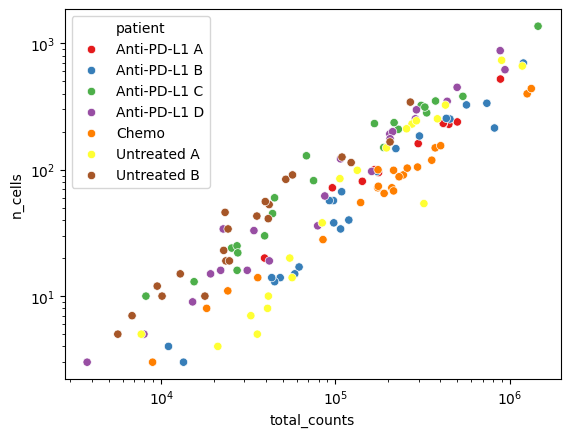

In [101]:
sns.scatterplot(data=pbulk_adata.obs, x='total_counts', y='n_cells', hue='patient', palette='Set1');
plt.xscale('log');plt.yscale('log');

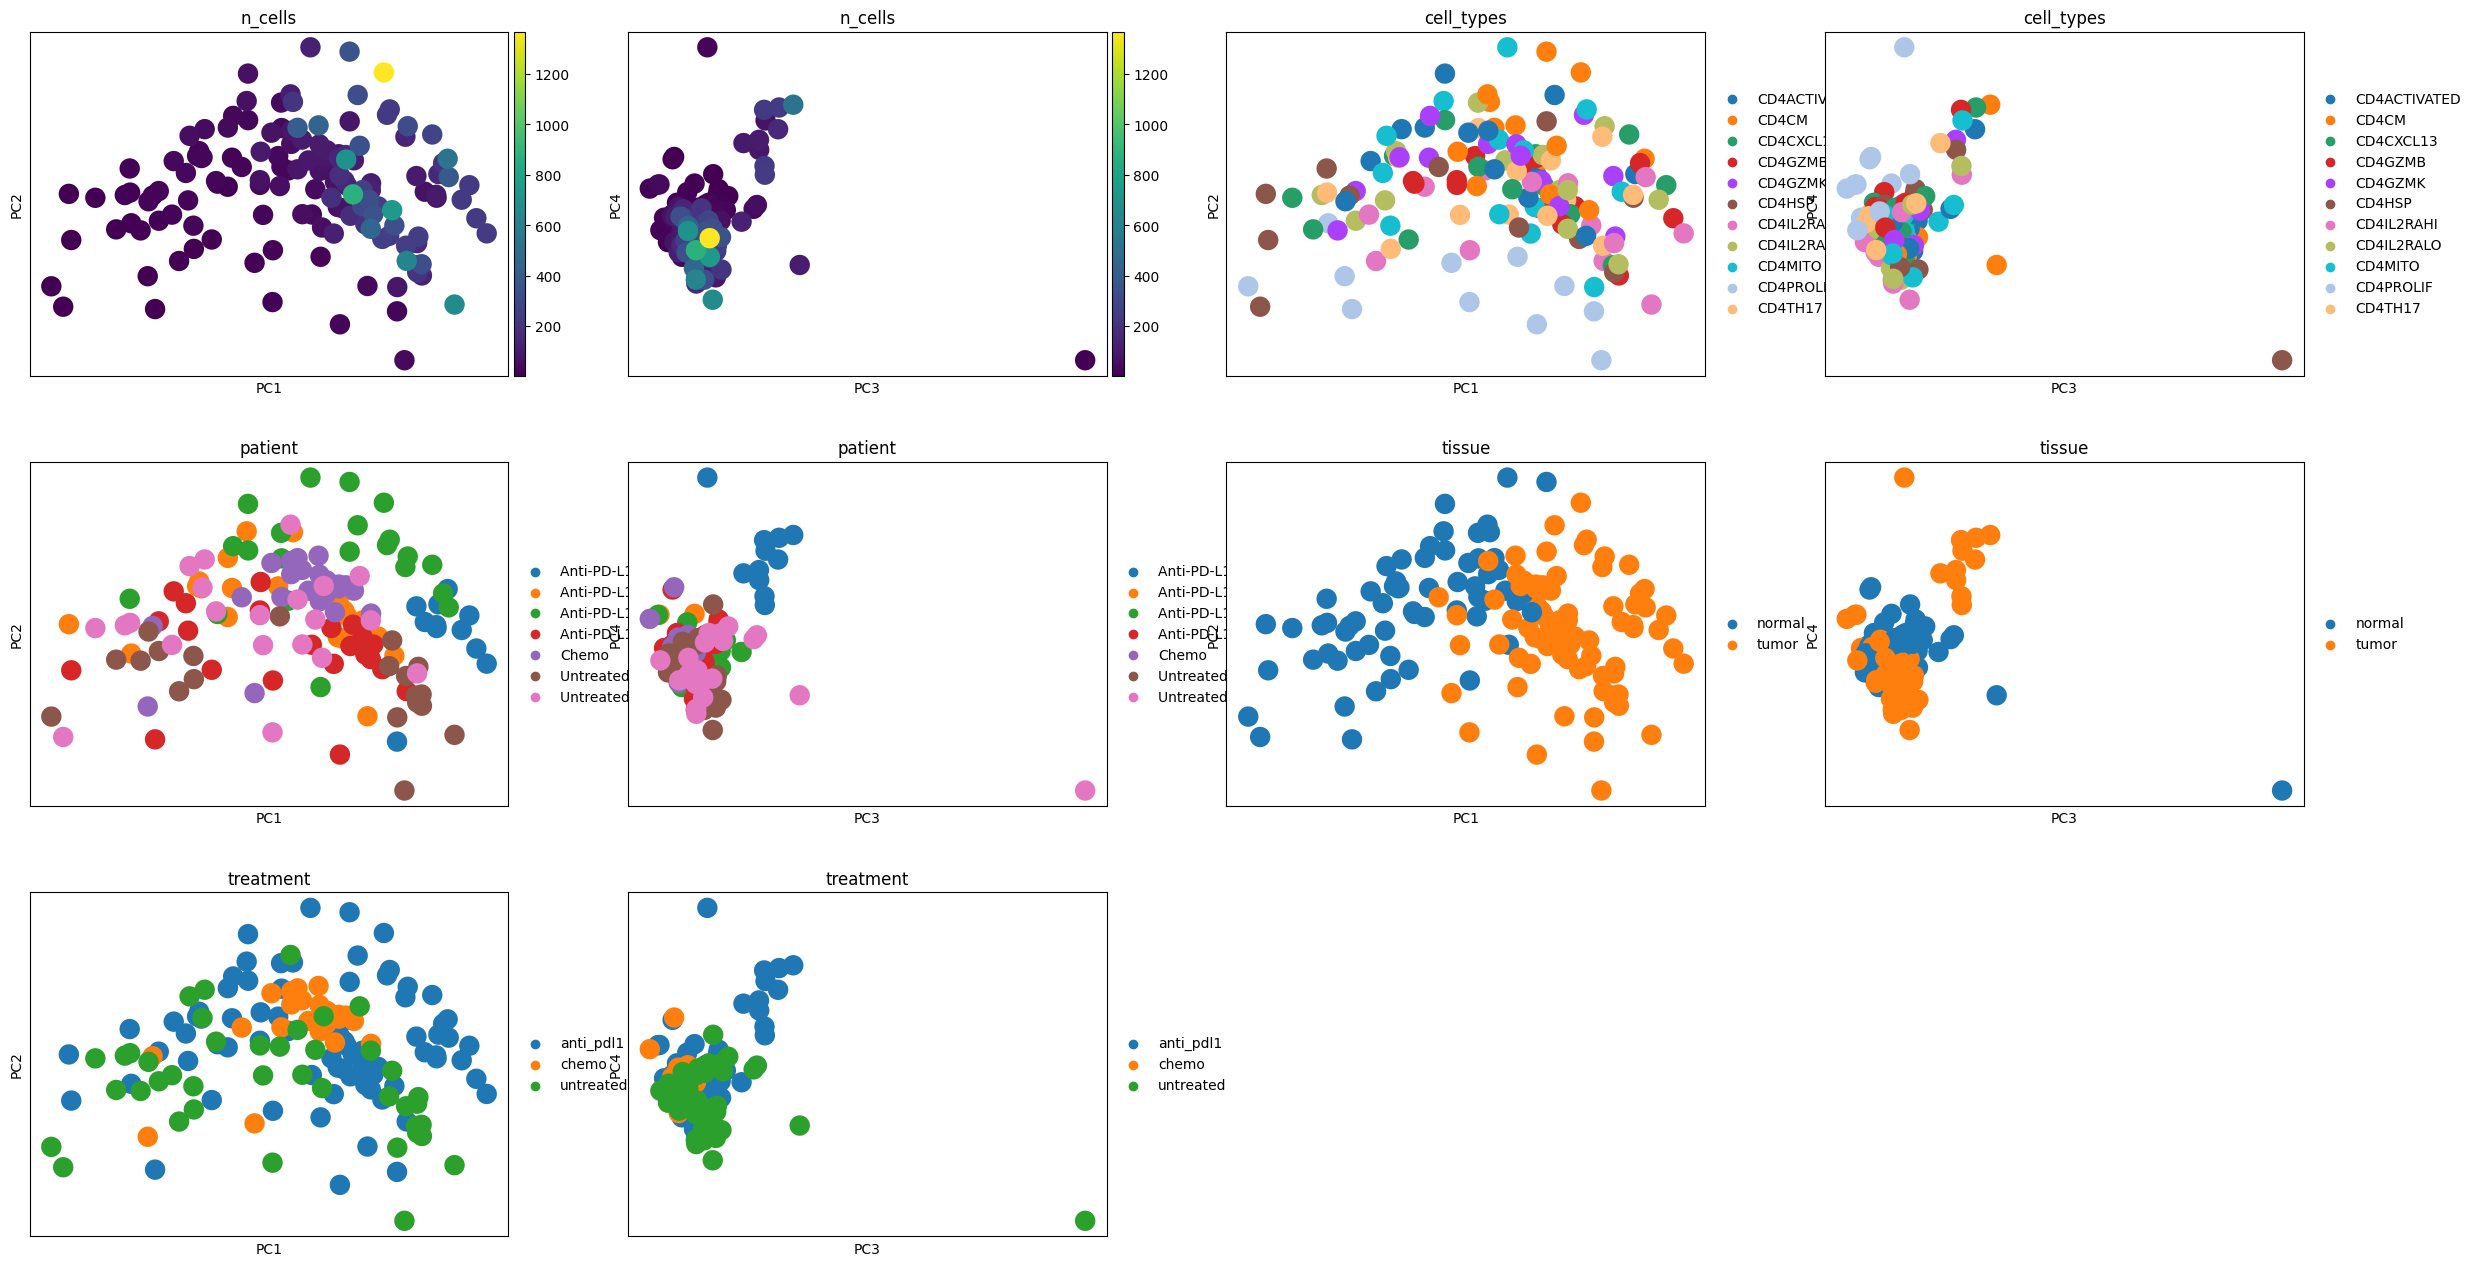

In [102]:
sc.pl.pca(pbulk_adata, color=['n_cells', 'cell_types', 'patient', 'tissue', 'treatment'], components=['1,2', '3,4'])

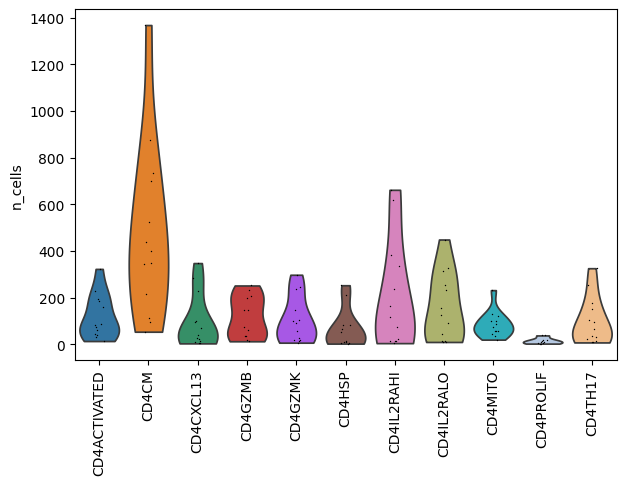

In [103]:
sc.pl.violin(pbulk_adata, 'n_cells',groupby='cell_types', rotation=90)

In [104]:
pbulk_adata[pbulk_adata.obs['tissue'] == 'tumor'].obs.sort_values('cell_types')

,Sample_ID,tissue,treatment,patient,cell_types,n_cells,total_counts
Anti-PD-L1 A tumor CD4_tumor_anti_pdl1_Anti-PD-L1 A_CD4ACTIVATED,Anti-PD-L1 A tumor CD4,tumor,anti_pdl1,Anti-PD-L1 A,CD4ACTIVATED,161,298591.0
Untreated A tumor CD4_tumor_untreated_Untreated A_CD4ACTIVATED,Untreated A tumor CD4,tumor,untreated,Untreated A,CD4ACTIVATED,230,274966.0
Untreated B tumor CD4_tumor_untreated_Untreated B_CD4ACTIVATED,Untreated B tumor CD4,tumor,untreated,Untreated B,CD4ACTIVATED,84,51854.0
Chemo tumor CD4_tumor_chemo_Chemo_CD4ACTIVATED,Chemo tumor CD4,tumor,chemo,Chemo,CD4ACTIVATED,88,231839.0
Anti-PD-L1 D tumor CD4_tumor_anti_pdl1_Anti-PD-L1 D_CD4ACTIVATED,Anti-PD-L1 D tumor CD4,tumor,anti_pdl1,Anti-PD-L1 D,CD4ACTIVATED,192,205084.0
...,...,...,...,...,...,...,...
Anti-PD-L1 D tumor CD4_tumor_anti_pdl1_Anti-PD-L1 D_CD4TH17,Anti-PD-L1 D tumor CD4,tumor,anti_pdl1,Anti-PD-L1 D,CD4TH17,176,205868.0
Chemo tumor CD4_tumor_chemo_Chemo_CD4TH17,Chemo tumor CD4,tumor,chemo,Chemo,CD4TH17,105,296098.0
Anti-PD-L1 B tumor CD4_tumor_anti_pdl1_Anti-PD-L1 B_CD4TH17,Anti-PD-L1 B tumor CD4,tumor,anti_pdl1,Anti-PD-L1 B,CD4TH17,326,565273.0
Anti-PD-L1 A tumor CD4_tumor_anti_pdl1_Anti-PD-L1 A_CD4TH17,Anti-PD-L1 A tumor CD4,tumor,anti_pdl1,Anti-PD-L1 A,CD4TH17,95,176741.0


In [105]:
sc.metrics.confusion_matrix('cell_types', 'Sample_ID',data=pbulk_adata[pbulk_adata.obs['tissue'] == 'tumor'].obs, normalize=False)

Sample_ID,Anti-PD-L1 A tumor CD4,Anti-PD-L1 B tumor CD4,Anti-PD-L1 C tumor CD4,Anti-PD-L1 D tumor CD4,Chemo tumor CD4,Untreated A tumor CD4,Untreated B tumor CD4
cell_types,,,,,,,
CD4ACTIVATED,1,1,1,1,1,1,1
CD4CM,1,1,1,1,1,1,1
CD4CXCL13,1,1,1,1,1,1,1
CD4GZMB,1,1,1,1,1,1,1
CD4GZMK,1,1,1,1,1,1,1
CD4HSP,1,1,1,1,1,1,1
CD4IL2RAHI,1,1,1,1,1,1,1
CD4IL2RALO,1,1,1,1,1,1,1
CD4MITO,1,1,1,1,1,1,1


/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/pydeseq2/dds.py:245: ImplicitModificationWarning: Modifying `X` on a view results in data being overridden
  self.X = adata.X.astype(int)
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/pydeseq2/dds.py:302: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = self.design
Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting LFCs...
... done in 0.01 seconds.

Running Wald tests...
... done in 1.31 seconds.



Log2 fold change & Wald test p-value, contrast vector: [1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
               baseMean  log2FoldChange     lfcSE      stat    pvalue  \
gene_name                                                               
AL627309.1     0.035569       -2.373907  4.977633 -0.476915  0.633423   
AP006222.2     0.009822       -2.373907  4.977633 -0.476915  0.633423   
RP11-206L10.2  0.221619       -1.535429  1.412848 -1.086761  0.277142   
RP11-206L10.9  0.103803       -1.544613  2.178879 -0.708903  0.478385   
FAM87B         0.015251       -2.373902  4.977633 -0.476914  0.633423   
...                 ...             ...       ...       ...       ...   
AC011841.1     0.130392       -2.373901  3.963559 -0.598932  0.549218   
AL354822.1     0.582648       -1.540327  1.621870 -0.949723  0.342253   
KIR2DL2        0.079893       -1.579548  4.898883 -0.322430  0.747127   
PNRC2-1        3.765030        1.758844  0.616651  2.852251  0.004341   
SRSF10-1       2.573735        1.4

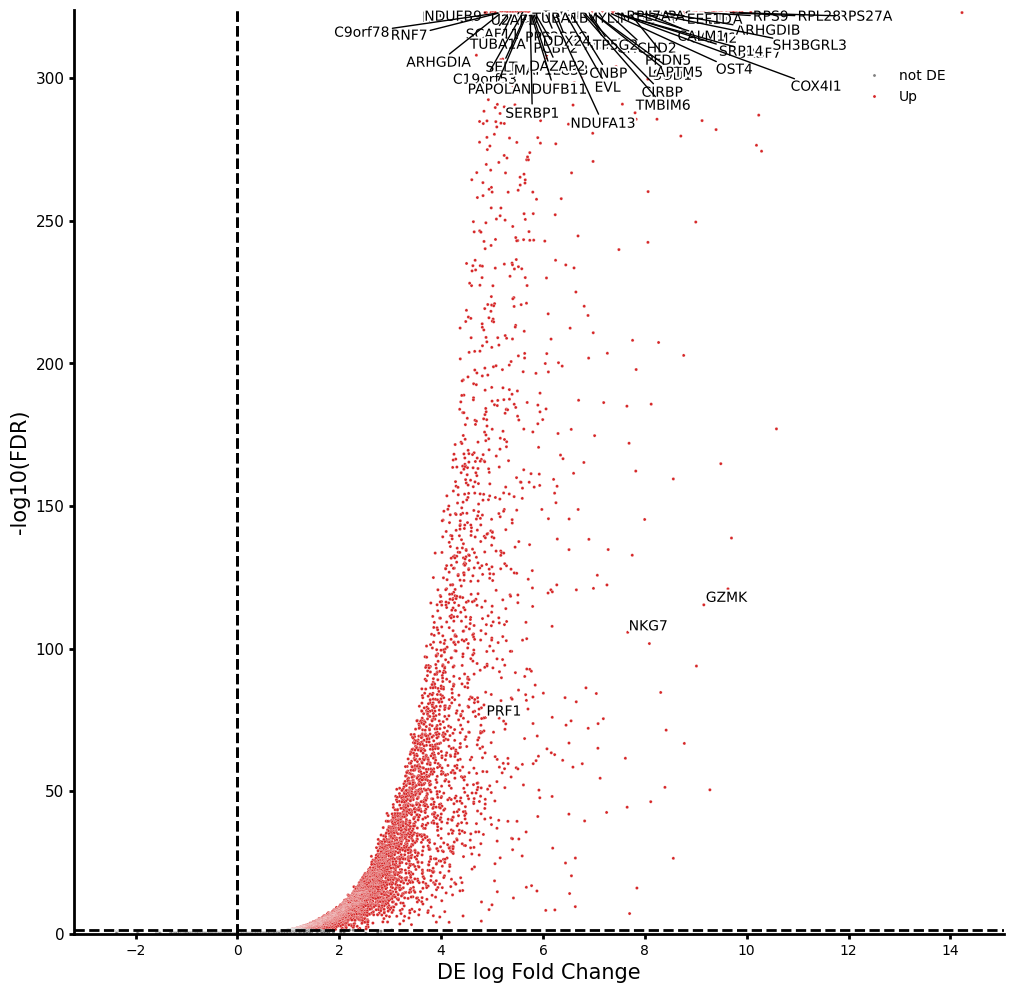

In [106]:
# model = pertpy.tl.PyDESeq2(pbulk_adata, design='~ tissue + patient_id + cell_types', layer='sum')
model = pertpy.tl.PyDESeq2(pbulk_adata[pbulk_adata.obs['tissue'] == 'tumor'], design='~ cell_types', layer='sum')
model.fit(quiet=True)

# Run differential expression for each polarization condition vs Th0
cytotoxic_contrast = model.cond(cell_types = 'CD4GZMK') 
res_df = model.test_contrasts(cytotoxic_contrast)
annot_gs = res_df[0:50].variable.tolist() + ['GZMK', 'PRF1', "NKG7"]

fig = model.plot_volcano(
    res_df, 
    log2fc_thresh=0, 
    return_fig=True, 
    to_label = annot_gs,
    figsize=(12, 12),
    s=5,
    legend_pos = (0.95,0.95),
    x_label = 'DE log Fold Change',
    y_label = '-log10(FDR)'
    )

/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/anndata/_core/anndata.py:1155: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/anndata/_core/anndata.py:1155: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/anndata/_core/anndata.py:1155: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/anndata/_core/anndata.py:1155: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/anndata/_core/anndata.py:1155: ImplicitModificationWarni

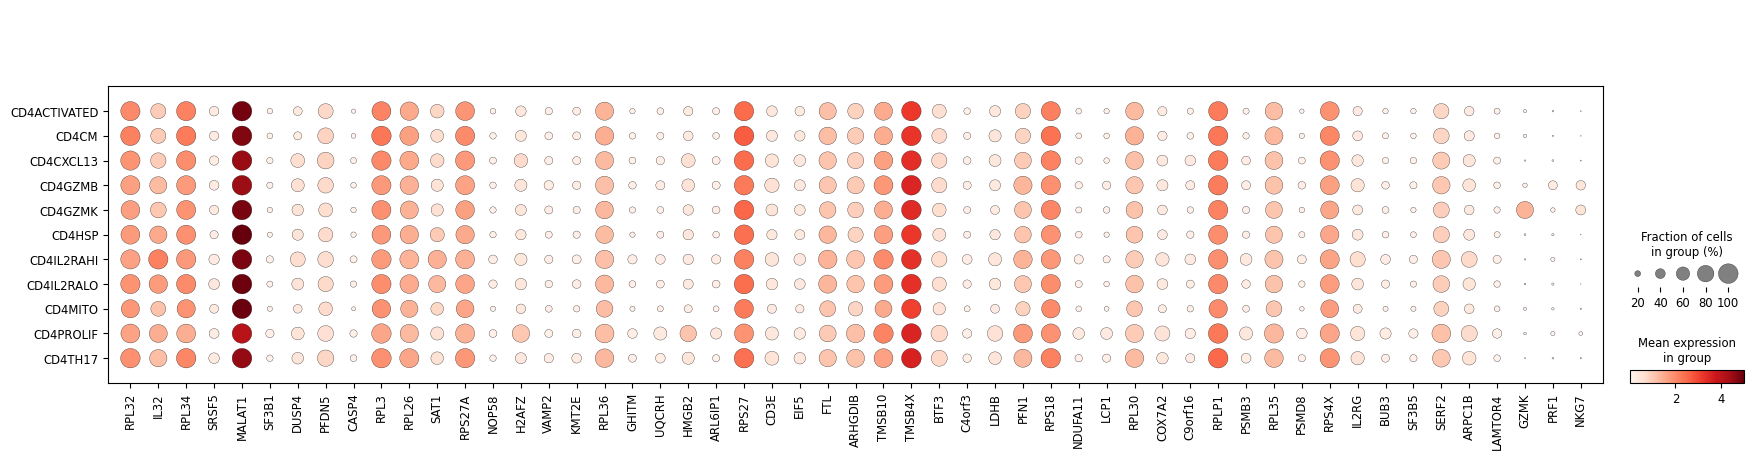

In [15]:
sc.pl.dotplot(adata[adata.obs['tissue'] == 'tumor'], annot_gs, groupby='cell_types')

Option 2 - cytotoxic vs CM

Running Wald tests...
... done in 0.72 seconds.



Log2 fold change & Wald test p-value, contrast vector: [ 0. -1.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
               baseMean  log2FoldChange     lfcSE      stat    pvalue  \
gene_name                                                               
RP11-206L10.2  0.223553        0.935710  1.868244  0.500850  0.616477   
RP11-206L10.9  0.105491        1.624695  3.070217  0.529179  0.596681   
LINC00115      0.587820        0.625484  1.034812  0.604442  0.545550   
FAM41C         0.016679        2.081780  7.033953  0.295962  0.767259   
KLHL17         0.179920        0.260703  2.959462  0.088091  0.929804   
...                 ...             ...       ...       ...       ...   
AL592183.1     8.706200       -0.490138  0.412877 -1.187129  0.235177   
AC011841.1     0.129330        0.752109  6.138877  0.122516  0.902491   
AL354822.1     0.564186        1.532764  2.259214  0.678450  0.497486   
KIR2DL2        0.074478        2.861070  6.979579  0.409920  0.681865   
PNRC2-1        3.744062

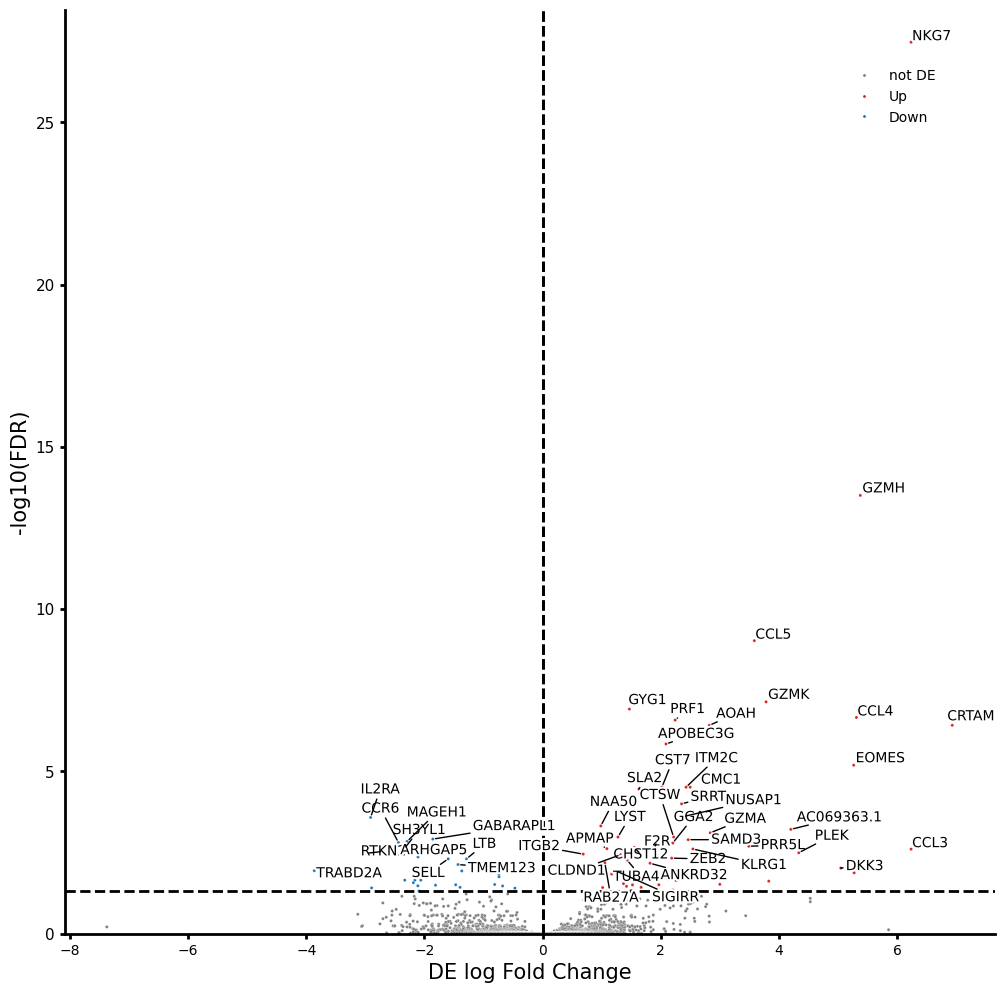

In [16]:
cytotoxic_contrast = model.cond(cell_types = 'CD4GZMK') - model.cond(cell_types = 'CD4CM') 
res_df = model.test_contrasts(cytotoxic_contrast)
annot_gs = res_df[0:50].variable.tolist() + ['GZMK', 'PRF1', "NKG7"]

fig = model.plot_volcano(
    res_df, 
    log2fc_thresh=0, 
    return_fig=True, 
    to_label = annot_gs,
    figsize=(12, 12),
    s=5,
    legend_pos = (0.95,0.95),
    x_label = 'DE log Fold Change',
    y_label = '-log10(FDR)'
    )

/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/anndata/_core/anndata.py:1155: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/anndata/_core/anndata.py:1155: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/anndata/_core/anndata.py:1155: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/anndata/_core/anndata.py:1155: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/anndata/_core/anndata.py:1155: ImplicitModificationWarni

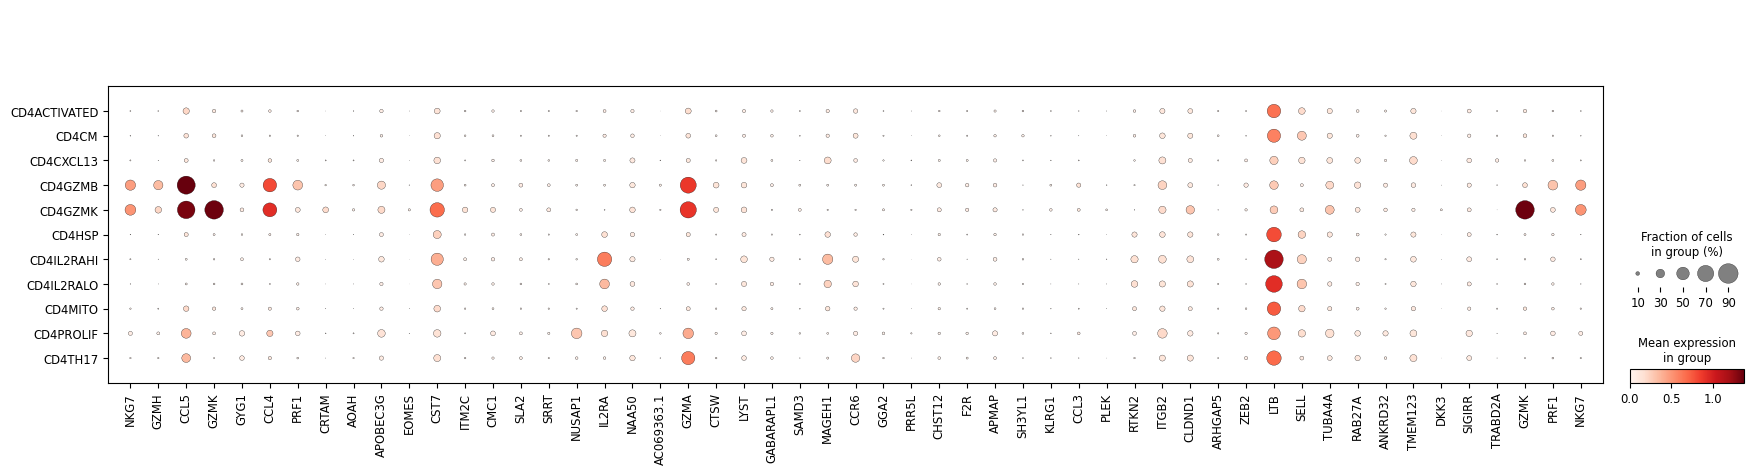

In [17]:
sc.pl.dotplot(adata[adata.obs['tissue'] == 'tumor'], annot_gs, groupby='cell_types')

Option 3 - one vs all but aggregating cytotoxic vs not cytotoxic

In [107]:
adata.obs['cytotoxic'] = np.where(adata.obs['cell_types'].isin(['CD4GZMK', 'CD4GZMB']), 'cytotoxic', 'other')
pbulk_adata = sc.get.aggregate(adata, by=['Sample_ID', 'tissue','treatment', 'patient','cytotoxic'], func=['sum'], layer='counts')
n_cells = adata.obs.groupby(['Sample_ID', 'tissue','treatment', 'patient','cytotoxic']).size().reset_index().rename({0:'n_cells'}, axis=1)

obs_df = pd.merge(pbulk_adata.obs, n_cells)
obs_df.index = pbulk_adata.obs_names.copy()
pbulk_adata.obs = obs_df.copy()
pbulk_adata = pbulk_adata[pbulk_adata.obs['n_cells'] >= 3].copy()

# HVGs
pbulk_adata.X = pbulk_adata.layers['sum'].copy()
sc.pp.normalize_total(pbulk_adata)
sc.pp.log1p(pbulk_adata)
sc.pp.highly_variable_genes(pbulk_adata, n_top_genes=20000)
pbulk_adata = pbulk_adata[:, pbulk_adata.var['highly_variable']].copy()
sc.pp.scale(pbulk_adata)
sc.pp.pca(pbulk_adata)
pbulk_adata.X = pbulk_adata.layers['sum'].copy()

/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/scanpy/preprocessing/_highly_variable_genes.py:415: UserWarning: `n_top_genes` > number of normalized dispersions, returning all genes with normalized dispersions.
  warnings.warn(msg, UserWarning)


/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/pydeseq2/dds.py:245: ImplicitModificationWarning: Modifying `X` on a view results in data being overridden
  self.X = adata.X.astype(int)
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/pydeseq2/dds.py:302: ImplicitModificationWarning: Setting element `.obsm['design_matrix']` of view, initializing view as actual.
  self.obsm["design_matrix"] = self.design
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/pydeseq2/dds.py:804: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
Fitting dispersions...
... done in 0.02 seconds.

Fitting MAP dispersions...
... done in 0.02 seconds.

Fitting LFCs...
... done in 0.02 seconds.

Running Wald tests...
... done in 1.14 seconds.



Log2 fold change & Wald test p-value, contrast vector: [ 0. -1.]
                baseMean  log2FoldChange     lfcSE      stat    pvalue  \
gene_name                                                                
AL627309.1      0.227797        0.265080  1.534576  0.172738  0.862857   
AP006222.2      0.145526        3.071902  3.365989  0.912630  0.361437   
RP11-206L10.2   1.411872        0.605213  0.877136  0.689987  0.490202   
RP11-206L10.9   0.752086        0.597765  1.007350  0.593404  0.552911   
FAM87B          0.137970        2.659713  2.116793  1.256482  0.208941   
...                  ...             ...       ...       ...       ...   
AC011841.1      0.220668       -0.126958  1.433001 -0.088596  0.929403   
AL354822.1      2.434437       -0.605379  1.551379 -0.390220  0.696374   
KIR2DL2         1.039896        4.188238  3.017477  1.387994  0.165139   
PNRC2-1        19.211866       -0.178067  0.902905 -0.197215  0.843659   
SRSF10-1       14.668947        0.222309  0.506

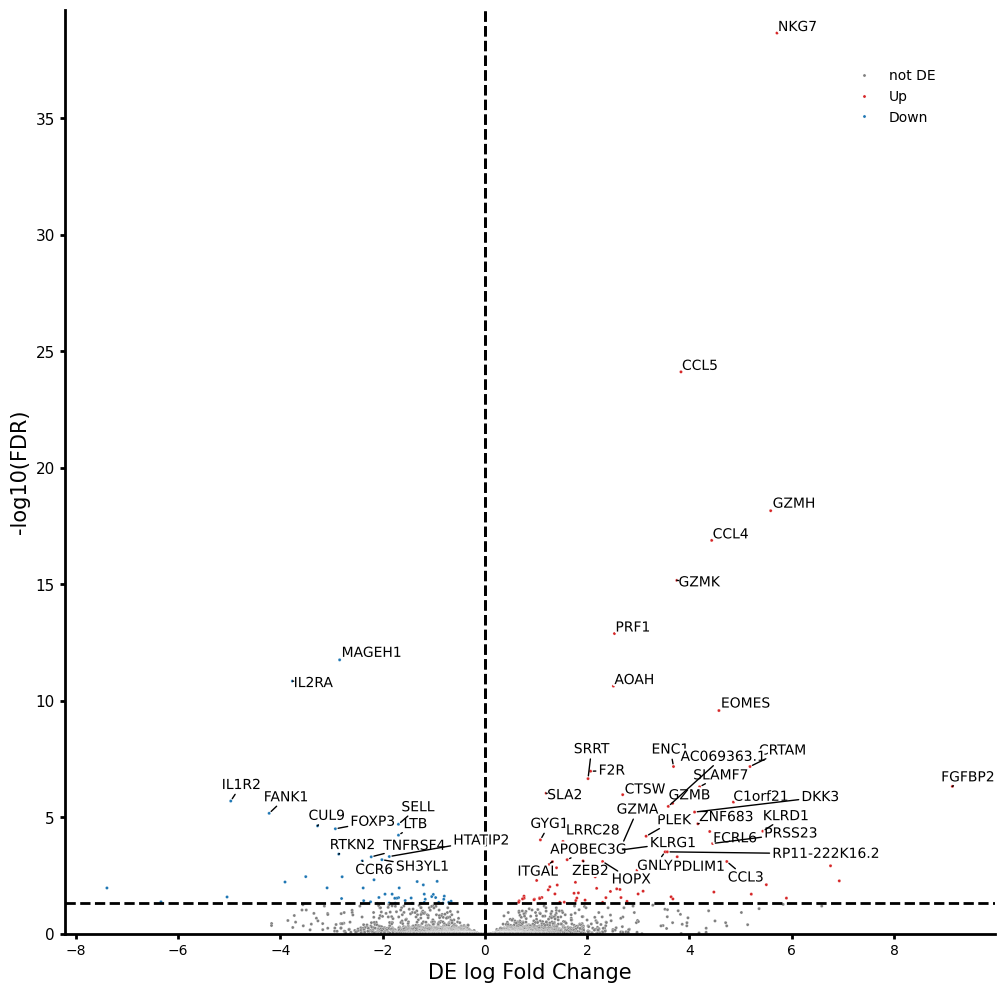

In [108]:
model = pertpy.tl.PyDESeq2(pbulk_adata[pbulk_adata.obs['tissue'] == 'tumor'], design='~ cytotoxic', layer='sum')
model.fit(quiet=True)

# Run differential expression for each polarization condition vs Th0
cytotoxic_contrast = model.cond(cytotoxic = 'cytotoxic') - model.cond(cytotoxic = 'other')
res_df = model.test_contrasts(cytotoxic_contrast)
annot_gs = res_df[0:50].variable.tolist() + ['GZMK', 'PRF1', "NKG7"]

fig = model.plot_volcano(
    res_df, 
    log2fc_thresh=0, 
    return_fig=True, 
    to_label = annot_gs,
    figsize=(12, 12),
    s=5,
    legend_pos = (0.95,0.95),
    x_label = 'DE log Fold Change',
    y_label = '-log10(FDR)'
    )

/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/anndata/_core/anndata.py:1155: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/anndata/_core/anndata.py:1155: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/anndata/_core/anndata.py:1155: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/anndata/_core/anndata.py:1155: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/anndata/_core/anndata.py:1155: ImplicitModificationWarni

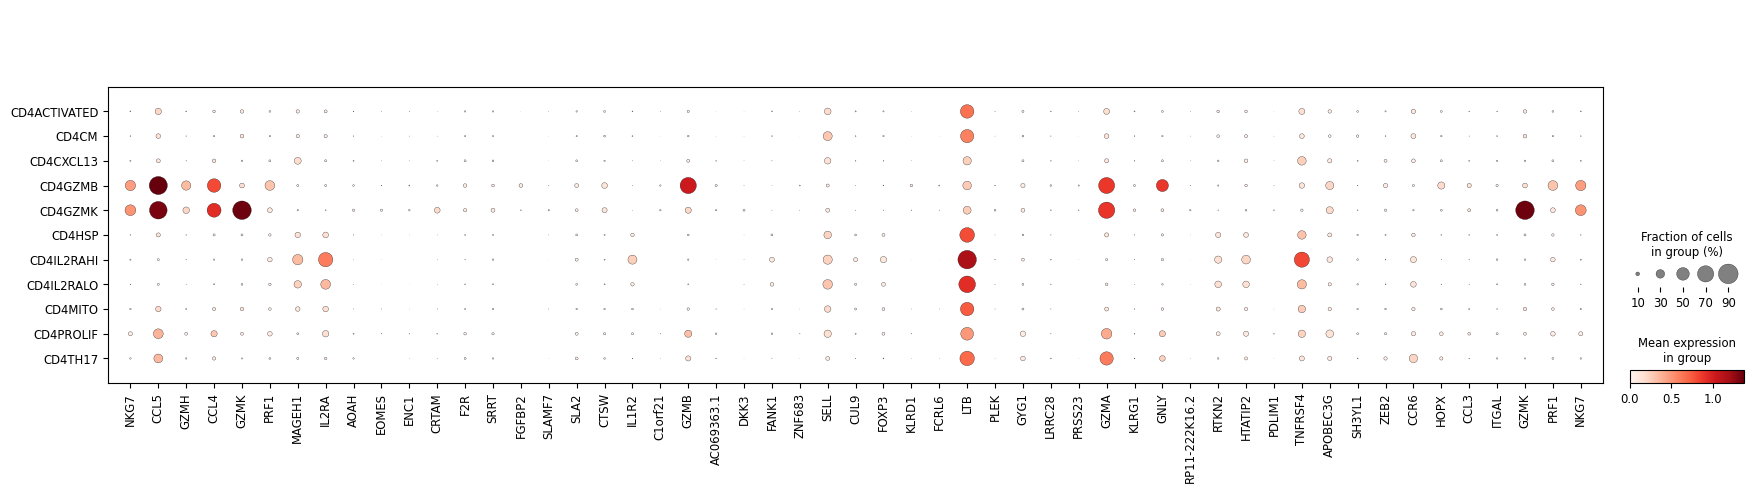

In [109]:
sc.pl.dotplot(adata[adata.obs['tissue'] == 'tumor'], annot_gs, groupby='cell_types')

 ### Save cytotoxicity signautre

/tmp/ipykernel_2307188/2840820864.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cytotoxic_signature['zscore'] = cytotoxic_signature['log_fc']/cytotoxic_signature['lfcSE']


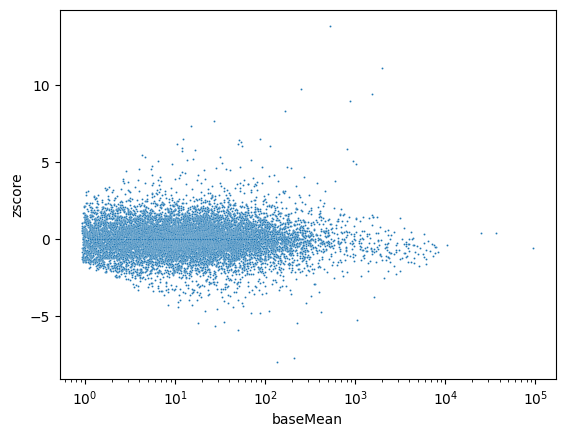

In [110]:
res_df['contrast'] = 'cytotoxic_vs_rest'
cytotoxic_signature = res_df.dropna()
cytotoxic_signature['zscore'] = cytotoxic_signature['log_fc']/cytotoxic_signature['lfcSE']
sns.scatterplot(data=cytotoxic_signature, x='baseMean', y='zscore', s=2);
plt.xscale('log')

cytotoxic_signature.to_csv('cytotoxicCD4_signature.csv')

In [12]:
cytotoxic_signature = pd.read_csv('cytotoxicCD4_signature.csv', index_col=0)

## Load perturb-seq signatures

In [21]:
# Import utility functions from DE_analysis_utils.py
import sys
import os
sys.path.append(os.path.abspath('../3_DE_analysis'))
from DE_analysis_utils import get_DE_results_long


In [22]:
datadir = '/mnt/oak/users/emma/data/GWT/CD4iR1_Psomagen/'
experiment_name = 'CD4iR1_Psomagen'
adata_de = sc.read_h5ad(datadir + f'/DE_results_all_confounders/{experiment_name}.merged_DE_results.h5ad')

adata_de.layers['zscore'] = adata_de.layers['log_fc'] / adata_de.layers['lfcSE']
adata_de.layers['zscore'][np.where(adata_de.layers['zscore'] > 50)] = 50
for cond in adata_de.obs.culture_condition.unique():
    affected_gs_cond = np.sum(adata_de[adata_de.obs['culture_condition'] == cond].layers['adj_p_value'] < 0.1, axis=0)
    adata_de.var[f'n_signif_effects_{cond}'] = affected_gs_cond
    # affected_gs_cond = np.sum(adata_de[adata_de.obs['culture_condition'] == cond].layers['MASH_lfsr'] < 0.05, axis=0)
    # adata_de.var[f'n_mash_signif_effects_{cond}'] = affected_gs_cond

adata_de.var_names = adata_de.var['gene_name'].values
adata_de.var_names

Index(['TSPAN6', 'DPM1', 'C1orf112', 'FGR', 'CFH', 'FUCA2', 'GCLC', 'NFYA',
       'STPG1', 'NIPAL3',
       ...
       'SMIM33', 'MSANTD7', 'SCO2', 'C2orf81', 'TBCE', 'ARHGAP11B', 'F8A1',
       'HOMEZ', 'ENSG00000290797', 'SOD2'],
      dtype='object', length=10079)

In [23]:
# Load summary stats
DE_stats = pd.read_csv(datadir + f'/DE_results_all_confounders/DE_summary_stats_per_target.csv', index_col=0)
keep_targets = DE_stats[ (DE_stats.n_total_de_genes > 1)].target_name.tolist()
print(len(keep_targets))

7402


In [8]:
k562_adata_de = sc.read_h5ad('/mnt/oak/users/emma/data/GWT/K562_DE_analysis/K562.merged_DE_results.h5ad')

k562_adata_de.layers['zscore'] = k562_adata_de.layers['log_fc'] / k562_adata_de.layers['lfcSE']
k562_adata_de.layers['zscore'][np.where(k562_adata_de.layers['zscore'] > 50)] = 50
k562_adata_de

AnnData object with n_obs × n_vars = 3081 × 6294
    obs: 'culture_condition', 'target_contrast', 'chunk', 'target_contrast_gene_name', 'n_cells_target'
    layers: 'adj_p_value', 'baseMean', 'lfcSE', 'log_fc', 'p_value', 'zscore'

## Fit signature

In [112]:
from perturb2tissue_eval import *


def unpack_state_results(model_results, state):
    return {
        'p2t_model': model_results[state]['p2t_model'],
        'p2t_model_k562': model_results[state]['p2t_model_k562'],
        'X_perturbs': model_results[state]['X_perturbs'],
        'y_target': model_results[state]['y_target'],
        'common_gs': model_results[state]['common_gs']
    }

### Comparison with K562 data
Subsetting to common perturbations

In [113]:
target_state = 'cytotoxic_vs_rest'
perturb_layer = 'zscore'
ctrl_de = k562_adata_de
n_pcs = 30
n_splits = 5
n_repeats = 1

# Get target state values
y_target = cytotoxic_signature.pivot_table(index='variable', columns='contrast', values=perturb_layer)[target_state]

# Find common genes between all DE results
common_gs = np.intersect1d(y_target.index, adata_de.var_names)
print(f"Common genes between target and adata_de: {len(common_gs)}")

if ctrl_de is not None:
    # Map gene IDs to gene names for K562 comparison
    common_gs_ids_df = adata_de[:, common_gs].var[['gene_ids', 'gene_name']]
    common_gs_ids = common_gs_ids_df[common_gs_ids_df.gene_name.isin(ctrl_de.var_names)].gene_name
    print(f"Common gene IDs with K562: {len(common_gs_ids)}")
    
    k562_de_test = ctrl_de[:, ctrl_de.var_names.isin(common_gs_ids)].copy()
    common_gs = np.intersect1d(common_gs, k562_de_test.var_names)

Common genes between target and adata_de: 7668
Common gene IDs with K562: 5530


In [114]:
y_target = y_target.loc[common_gs]

# Get responses in stim cells
print(f"Getting perturbation responses for condition: {cond}")
X_perturbs = sc.get.obs_df(adata_de[adata_de.obs.culture_condition == cond], 
                            ['target_contrast_gene_name'] + list(common_gs), 
                            layer=perturb_layer)
X_perturbs = X_perturbs.set_index('target_contrast_gene_name').T
print(f"Perturbation matrix shape: {X_perturbs.shape}")

if ctrl_de is not None:
    X_perturbs_ctrl = sc.get.obs_df(k562_de_test, 
                            ['target_contrast_gene_name'] + list(common_gs), 
                            layer=perturb_layer)
    X_perturbs_ctrl = X_perturbs_ctrl.set_index('target_contrast_gene_name').T
    # Find common perturbations between CD4 and K562
    common_perturbs = np.intersect1d(X_perturbs_ctrl.columns, X_perturbs.columns)
    print(f"Common perturbations between CD4 and K562: {len(common_perturbs)}")
    X_perturbs = X_perturbs[common_perturbs]
    X_perturbs_ctrl = X_perturbs_ctrl[common_perturbs]
    X_perturbs_ctrl_masked = X_perturbs_ctrl.copy()
    mask = pd.DataFrame(False, index=X_perturbs_ctrl_masked.index, columns=X_perturbs_ctrl_masked.columns)
    for idx in X_perturbs_ctrl_masked.index:
        if idx in X_perturbs_ctrl_masked.columns:
            mask.loc[idx, idx] = True
    X_perturbs_ctrl_masked = X_perturbs_ctrl_masked.mask(mask)
    # Impute masked values with column means
    X_perturbs_ctrl_masked = X_perturbs_ctrl_masked.fillna(X_perturbs_ctrl_masked.mean())

# Mask effects in cis
X_perturbs_masked = X_perturbs.copy()
mask = pd.DataFrame(False, index=X_perturbs_masked.index, columns=X_perturbs_masked.columns)
for idx in X_perturbs_masked.index:
    if idx in X_perturbs_masked.columns:
        mask.loc[idx, idx] = True
X_perturbs_masked = X_perturbs_masked.mask(mask)
# Impute masked values with column means
X_perturbs_masked = X_perturbs_masked.fillna(X_perturbs_masked.mean())

# Train model on CD4 cells
print(f"Training CD4 model with {n_pcs} PCs, {n_splits} splits, {n_repeats} repeats")
p2t_model = Perturb2TissueModel(pca_transform=True, n_pcs=n_pcs, n_splits=n_splits, n_repeats=n_repeats, positive=False)
p2t_model.fit(X_perturbs_masked, y_target, model_id=f'{cond}')
print(f"CD4 model training complete.")

# Train model on K562 cells if provided
p2t_model_k562 = None
if ctrl_de is not None:
    print(f"Training K562 model with {n_pcs} PCs, {n_splits} splits, {n_repeats} repeats")
    p2t_model_k562 = Perturb2TissueModel(pca_transform=True, n_pcs=n_pcs, n_splits=n_splits, n_repeats=n_repeats, positive=False)
    p2t_model_k562.fit(X_perturbs_ctrl_masked, y_target, model_id=f'K562')
    print(f"K562 model training complete.")

print(f"Model training for {target_state} completed successfully")



Getting perturbation responses for condition: Rest
Perturbation matrix shape: (5530, 8481)
Common perturbations between CD4 and K562: 2950
Training CD4 model with 30 PCs, 5 splits, 1 repeats
CD4 model training complete.
Training K562 model with 30 PCs, 5 splits, 1 repeats
K562 model training complete.
Model training for cytotoxic_vs_rest completed successfully


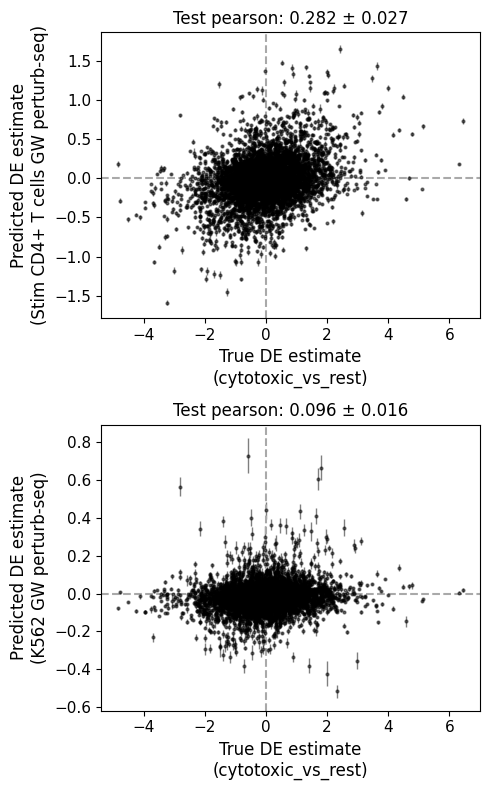

In [115]:
st = target_state
common_gs_ids_df = adata_de[:, common_gs].var[['gene_ids', 'gene_name']]
common_gs_ids = common_gs_ids_df.gene_ids

# Create a figure with subplots for all conditions
fig, axes = plt.subplots(2, 1, figsize=(5, 8))

# Plot predictions for the main model in the top subplot
p2t_model.plot_prediction(X_perturbs, y_target, plot_metric='pearson', ax=axes[0], return_ax=True)
axes[0].set_ylabel('Predicted DE estimate\n(Stim CD4+ T cells GW perturb-seq)', fontsize=12)
axes[0].set_xlabel(f'True DE estimate\n({st})', fontsize=12)
axes[0].axhline(y=0, color='darkgrey', linestyle='--')
axes[0].axvline(x=0, color='darkgrey', linestyle='--')

# Plot predictions for the K562 model in the bottom subplot
p2t_model_k562.plot_prediction(X_perturbs_ctrl, y_target, plot_metric='pearson', ax=axes[1], return_ax=True)
axes[1].set_ylabel('Predicted DE estimate\n(K562 GW perturb-seq)', fontsize=12)
axes[1].set_xlabel(f'True DE estimate\n({st})', fontsize=12)
axes[1].axhline(y=0, color='darkgrey', linestyle='--')
axes[1].axvline(x=0, color='darkgrey', linestyle='--')

plt.tight_layout()
plt.show()


In [118]:
target_state = 'cytotoxic_vs_rest'
perturb_layer = 'zscore'
ctrl_de = k562_adata_de
n_pcs = 60
n_splits = 5
n_repeats = 1
cond = 'Rest'

# Get target state values
y_target = cytotoxic_signature.pivot_table(index='variable', columns='contrast', values=perturb_layer)[target_state]

# Find common genes between all DE results
common_gs = np.intersect1d(y_target.index, adata_de.var_names)

y_target = y_target.loc[common_gs]

# Get responses in stim cells
print(f"Getting perturbation responses for condition: {cond}")
X_perturbs = sc.get.obs_df(adata_de[adata_de.obs.culture_condition == cond], 
                            ['target_contrast_gene_name'] + list(common_gs), 
                            layer=perturb_layer)
X_perturbs = X_perturbs.set_index('target_contrast_gene_name').T
print(f"Perturbation matrix shape: {X_perturbs.shape}")

# Mask effects in cis
X_perturbs_masked = X_perturbs.copy()
mask = pd.DataFrame(False, index=X_perturbs_masked.index, columns=X_perturbs_masked.columns)
for idx in X_perturbs_masked.index:
    if idx in X_perturbs_masked.columns:
        mask.loc[idx, idx] = True
X_perturbs_masked = X_perturbs_masked.mask(mask)
# Impute masked values with column means
X_perturbs_masked = X_perturbs_masked.fillna(X_perturbs_masked.mean())

# Train model on CD4 cells
print(f"Training CD4 model with {n_pcs} PCs, {n_splits} splits, {n_repeats} repeats")
p2t_model = Perturb2TissueModel(pca_transform=True, n_pcs=n_pcs, n_splits=n_splits, n_repeats=n_repeats, positive=False)
p2t_model.fit(X_perturbs_masked, y_target, model_id=f'{cond}')

Getting perturbation responses for condition: Rest
Perturbation matrix shape: (7668, 8481)
Training CD4 model with 60 PCs, 5 splits, 1 repeats


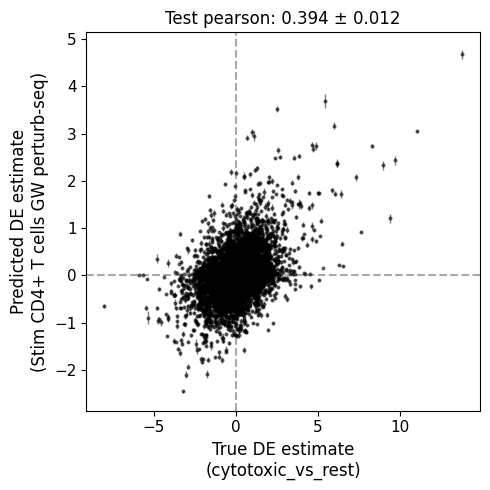

In [122]:
st = target_state
common_gs_ids_df = adata_de[:, common_gs].var[['gene_ids', 'gene_name']]
common_gs_ids = common_gs_ids_df.gene_ids

# Create a figure with subplots for all conditions
fig, axes = plt.subplots(1, 1, figsize=(5, 5))

# Process each state
# Plot predictions for the main model in the top subplot
p2t_model.plot_prediction(X_perturbs, y_target, plot_metric='pearson', ax=axes, return_ax=True)
axes.set_ylabel('Predicted DE estimate\n(Stim CD4+ T cells GW perturb-seq)', fontsize=12)
axes.set_xlabel(f'True DE estimate\n({st})', fontsize=12)
axes.axhline(y=0, color='darkgrey', linestyle='--')
axes.axvline(x=0, color='darkgrey', linestyle='--')

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'cytotoxic_vs_rest')

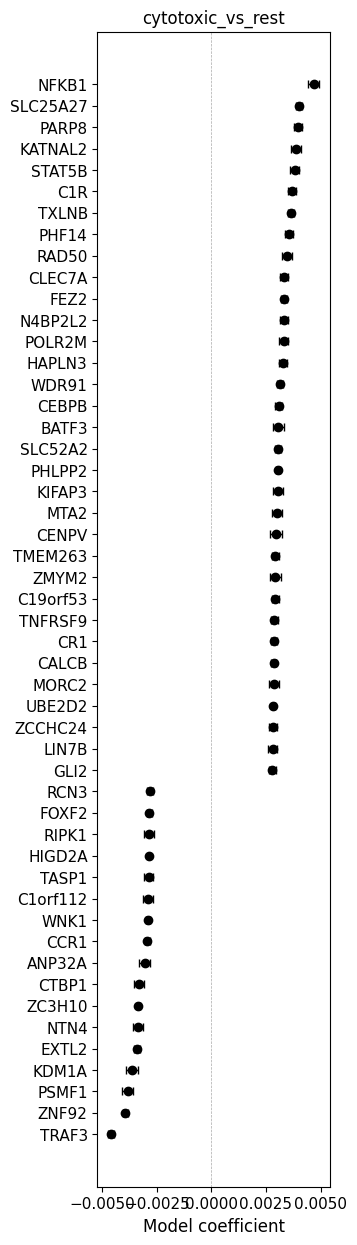

In [126]:
# Create a figure with subplots for all states in one row
fig, ax = plt.subplots(1, 1, figsize=(3, 15))
p2t_model.plot_coefs(top_n=50, ax=ax, return_ax=True, show_labels=True)
ax.set_title(st)


Text(0.5, 1.0, 'cytotoxic_vs_rest')

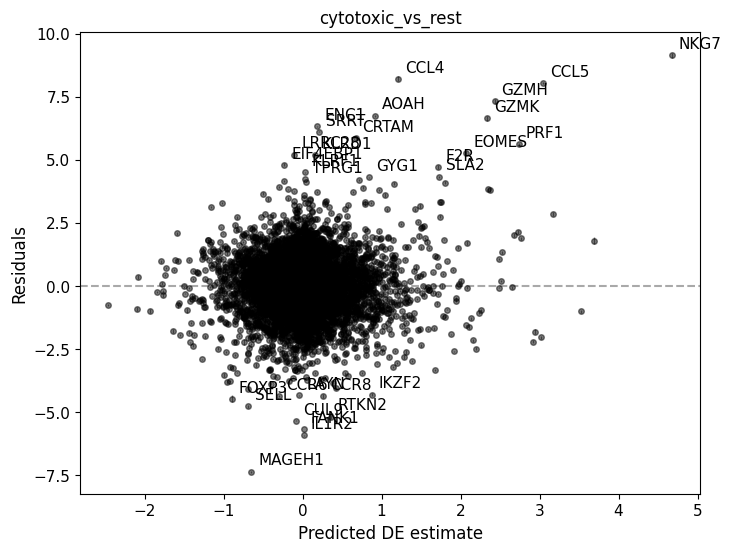

In [128]:
pl = p2t_model.plot_residuals(X_perturbs, y_target, annotate_top_n=30)
plt.title(st)

In [129]:
all_coefs = pd.DataFrame()
pt_coefs = p2t_model.get_coefs()
pt_coefs['state'] = st
all_coefs = pd.concat([all_coefs, pt_coefs])

In [132]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

top_quant = 0.005
alpha = 0.05

# Get DE geens with activation (Arce et al)
act_signature_df = pd.read_csv('Arce2024_20230130_DESeq2_output_AAVS1_Teff_Stimulation_vs_Resting.csv')
act_signature_df['zscore'] = act_signature_df['log2FoldChange']/act_signature_df['lfcSE']
activation_genes = act_signature_df[(act_signature_df['zscore'].abs() > 5) & (act_signature_df['padj'] < 0.01)]['gene_name']

# Get top DE genes for input signature
state_results_df = cytotoxic_signature[cytotoxic_signature['contrast'] == st]
pl_df = pd.merge(cytotoxic_signature, act_signature_df.rename({'zscore':'zscore_act', 'gene_name':'variable'}, axis=1)[['zscore_act', 'variable']])
state_results_df['activation_genes'] = state_results_df['variable'].isin(activation_genes)
signature_effect_size = state_results_df[state_results_df['adj_p_value'] < alpha].sort_values('zscore')
signature_gs = signature_effect_size.variable.tolist()

# Get top and bottom 10% of coefficient values
n = len(all_coefs['coef_mean'])
st_coefs = all_coefs[all_coefs['state'] == st].copy()
top_10_percent = st_coefs['coef_mean'].nlargest(int(n * top_quant))
bottom_10_percent = st_coefs['coef_mean'].nsmallest(int(n * top_quant))
predicted_effect_size = pd.concat([top_10_percent, bottom_10_percent]).sort_values(ascending=False)
predicted_regulators = predicted_effect_size.index.tolist()

# Get DE results and pivot to wide format
long_de_results = get_DE_results_long(adata_de, targets=predicted_regulators, genes=signature_gs, gene_id_col='gene_name')
long_de_results = long_de_results[long_de_results['culture_condition'] == 'Stim8hr'].copy()
wide_de_results = long_de_results.pivot(index='gene', columns='target_contrast_gene_name', values='zscore')
wide_de_results_signif = long_de_results.pivot(index='gene', columns='target_contrast_gene_name', values='adj_p_value')

# Create a mask where column names match index names and set those values to 0
mask = pd.DataFrame(False, index=wide_de_results.index, columns=wide_de_results.columns)
for idx in wide_de_results.index:
    if idx in wide_de_results.columns:
        mask.loc[idx, idx] = True
wide_de_results = wide_de_results.mask(mask, 0)
wide_de_results = wide_de_results.T

# Define axis labels
wide_de_results.index.name = 'Regulators (CRISPRi targets)'
wide_de_results.columns.name = f'{st} signature genes (5% FDR)'

<Figure size 3000x1500 with 0 Axes>

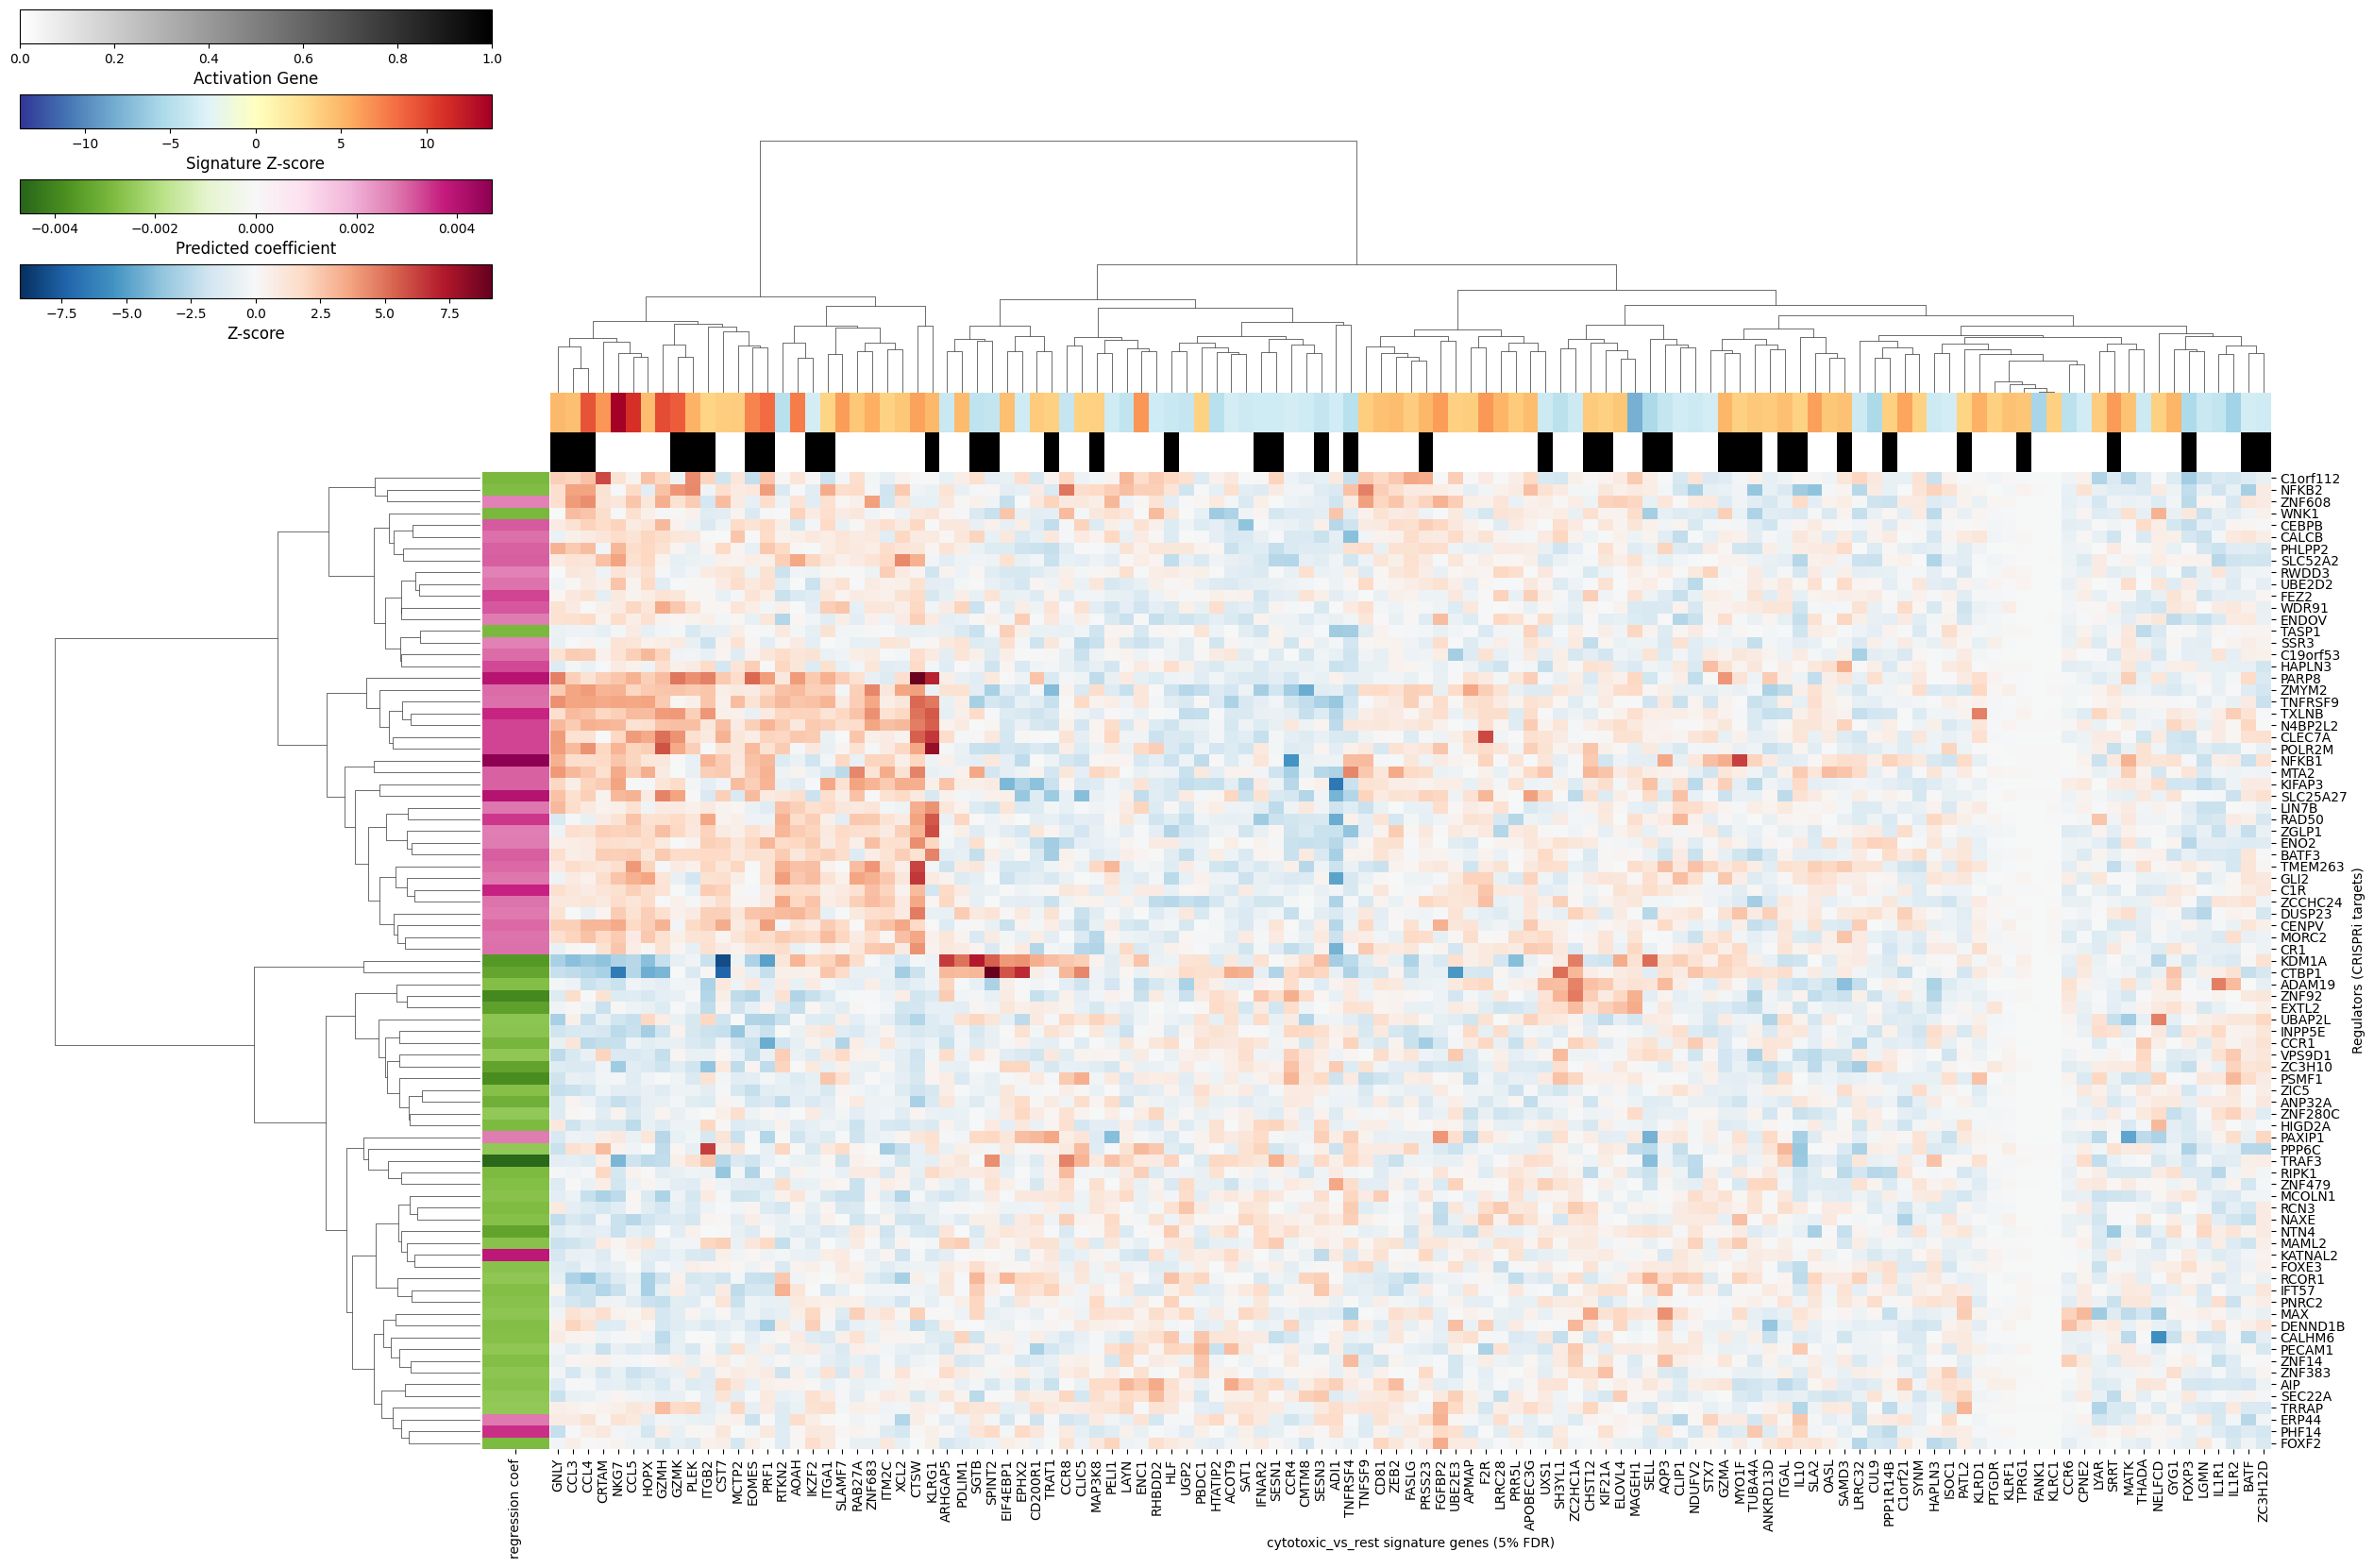

In [134]:
# Create row annotation dataframe with predicted effect sizes (now rows after transpose)
row_annot = pd.DataFrame({
    'regression coef': predicted_effect_size[wide_de_results.index]
})

# Create column annotation dataframe with signature zscores (now columns after transpose)
col_annot = pd.DataFrame({
    'zscore': signature_effect_size.set_index('variable').loc[wide_de_results.columns, 'zscore'],
    'activation_gene': signature_effect_size.set_index('variable').loc[wide_de_results.columns, 'activation_genes']
})

# Create different color maps for annotations
cmap_row = plt.cm.PiYG_r    # Pink-Yellow-Green for row annotation (predicted effect size)
cmap_col = plt.cm.RdYlBu_r  # Red-Yellow-Blue for column annotation (signature zscore)
cmap_activation = plt.cm.binary  # Binary colormap for activation genes

# Center the colormaps at 0 by using symmetric vmin/vmax
vmax_row = max(abs(row_annot['regression coef'].min()), abs(row_annot['regression coef'].max()))
vmax_col = max(abs(col_annot['zscore'].min()), abs(col_annot['zscore'].max()))
# Create color series for annotations (seaborn expects Series, not DataFrame with RGBA)
row_colors = row_annot['regression coef'].apply(lambda x: cmap_row((x + vmax_row) / (2 * vmax_row)))
col_colors = col_annot['zscore'].apply(lambda x: cmap_col((x + vmax_col) / (2 * vmax_col)))
activation_colors = col_annot['activation_gene'].apply(lambda x: cmap_activation(1.0 if x else 0.0))

# Create the clustermap
plt.figure(figsize=(30, 15))
g = sns.clustermap(wide_de_results,
                   cmap='RdBu_r',
                   center=0,
                   row_cluster=True,
                   col_cluster=True,
                   xticklabels=True,
                   yticklabels=True,
                   method='ward',
                   figsize=(25, 18),
                   row_colors=row_colors,
                   col_colors=[col_colors, activation_colors],
                   cbar_pos=None)

# Adjust layout to make room for additional colorbars
plt.subplots_adjust(top=0.85)

# Add colorbars for annotations - all same width and height
colorbar_width = 0.2
colorbar_height = 0.02
colorbar_left = 0

# Main heatmap colorbar - bottom
cbar_ax_main = g.fig.add_axes([colorbar_left, 0.75, colorbar_width, colorbar_height])
vmax_main = max(abs(wide_de_results.min().min()), abs(wide_de_results.max().max()))
sm_main = plt.cm.ScalarMappable(cmap='RdBu_r', norm=plt.Normalize(vmin=-vmax_main, vmax=vmax_main))
sm_main.set_array([])
cbar_main = plt.colorbar(sm_main, cax=cbar_ax_main, orientation='horizontal')
cbar_main.set_label('Z-score', fontsize=12)

# Row annotation colorbar (predicted effect size)
cbar_ax_row = g.fig.add_axes([colorbar_left, 0.80, colorbar_width, colorbar_height])
sm_row = plt.cm.ScalarMappable(cmap=cmap_row, norm=plt.Normalize(vmin=-vmax_row, vmax=vmax_row))
sm_row.set_array([])
cbar_row = plt.colorbar(sm_row, cax=cbar_ax_row, orientation='horizontal')
cbar_row.set_label('Predicted coefficient', fontsize=12)

# Column annotation colorbar (signature zscore)
cbar_ax_col = g.fig.add_axes([colorbar_left, 0.85, colorbar_width, colorbar_height])
sm_col = plt.cm.ScalarMappable(cmap=cmap_col, norm=plt.Normalize(vmin=-vmax_col, vmax=vmax_col))
sm_col.set_array([])
cbar_col = plt.colorbar(sm_col, cax=cbar_ax_col, orientation='horizontal')
cbar_col.set_label('Signature Z-score', fontsize=12)

# Activation gene colorbar
cbar_ax_activation = g.fig.add_axes([colorbar_left, 0.90, colorbar_width, colorbar_height])
sm_activation = plt.cm.ScalarMappable(cmap=cmap_activation, norm=plt.Normalize(vmin=0, vmax=1))
sm_activation.set_array([])
cbar_activation = plt.colorbar(sm_activation, cax=cbar_ax_activation, orientation='horizontal')
cbar_activation.set_label('Activation Gene', fontsize=12)
cbar_col.set_label('Signature Z-score', fontsize=12)

# Rotate x-axis labels
plt.setp(g.ax_heatmap.get_xticklabels(), rotation=90, ha='center')

plt.show()

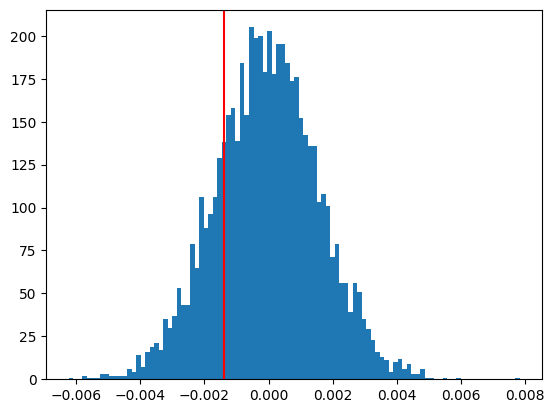

In [622]:
plt.hist(all_coefs['coef_mean'], bins=100);
plt.axvline(all_coefs.loc['ZBTB7B']['coef_mean'], color='red');

In [623]:
adata_de.obs[adata_de.obs['target_contrast_gene_name'].str.startswith('ZBTB')]

,target_contrast_gene_name,culture_condition,target_contrast,chunk,n_cells_target
ENSG00000198081_Stim8hr,ZBTB14,Stim8hr,ENSG00000198081,4,70.0
ENSG00000205189_Rest,ZBTB10,Rest,ENSG00000205189,7,89.0
ENSG00000186130_Rest,ZBTB6,Rest,ENSG00000186130,12,54.0
ENSG00000177125_Rest,ZBTB34,Rest,ENSG00000177125,19,122.0
ENSG00000236104_Stim8hr,ZBTB22,Stim8hr,ENSG00000236104,30,652.0
ENSG00000169155_Stim8hr,ZBTB43,Stim8hr,ENSG00000169155,33,204.0
ENSG00000126804_Rest,ZBTB1,Rest,ENSG00000126804,34,225.0
ENSG00000173276_Rest,ZBTB21,Rest,ENSG00000173276,35,609.0
ENSG00000236104_Rest,ZBTB22,Rest,ENSG00000236104,36,654.0
ENSG00000089775_Stim8hr,ZBTB25,Stim8hr,ENSG00000089775,48,267.0


### Check single-cell profiles

In [4]:
import sys
sys.path.append('..')
from utils import load_cells

In [98]:
h5ad_files = glob.glob('/mnt/oak/users/emma/data/GWT/CD4iR1_Psomagen' + '/tmp/CD4i_R1*Rest*.scRNA.postQC.h5ad')
obs_filt = {
    'guide_id':['PARP8-1', 'PARP8-2', 'NTC-001', 'NTC-002', 'NTC-004', 'NTC-006', 'NTC-005',]
}
adata_sc = load_cells(h5ad_files, obs_filt, to_memory=False)

Reading files:   0%|          | 0/46 [00:00<?, ?it/s]

In [99]:
adata_sc

AnnData object with n_obs × n_vars = 678 × 18114
    obs: 'library_id', 'lane_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_genes', 'top_guide_UMI_counts', 'guide_id', 'sequence', 'perturbed_gene_name', 'perturbed_gene_id', 'guide_type', 'low_quality', 'target_lognorm_expr'
    var: 'gene_ids', 'gene_name'

In [100]:
adata_sc.var_names = adata_sc.var['gene_name'].values 

In [101]:
adata_sc.layers['counts'] = adata_sc.X.copy()

In [102]:
sc.pp.normalize_total(adata_sc)
sc.pp.log1p(adata_sc)

In [103]:
sc.pp.highly_variable_genes(adata_sc)

In [104]:
# Get top DE genes for input signature
state_results_df = cytotoxic_signature[cytotoxic_signature['contrast'] == 'cytotoxic_vs_rest']
signature_effect_size = state_results_df[(state_results_df['adj_p_value'] < 0.01) & (state_results_df['log_fc'] > 0)].sort_values('zscore')
signature_gs = signature_effect_size.variable.tolist()

In [105]:
sc.tl.score_genes(adata_sc, signature_gs)

In [106]:
sc.pp.pca(adata_sc)

In [107]:
adata_sc.obs['donor_id'] = adata_sc.obs_names.str.split("_").str[5]

<Axes: xlabel='perturbed_gene_name', ylabel='score'>

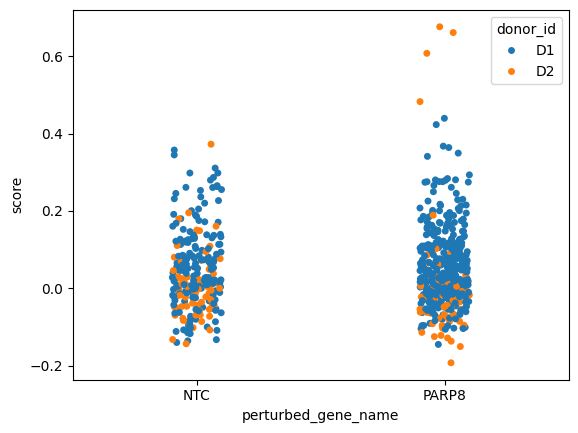

In [111]:
g = 'GZMK'
pl_df = sc.get.obs_df(adata_sc, [g, 'score', 'donor_id', 'perturbed_gene_name'])
sns.stripplot(data=pl_df, x='perturbed_gene_name', y='score', hue='donor_id')

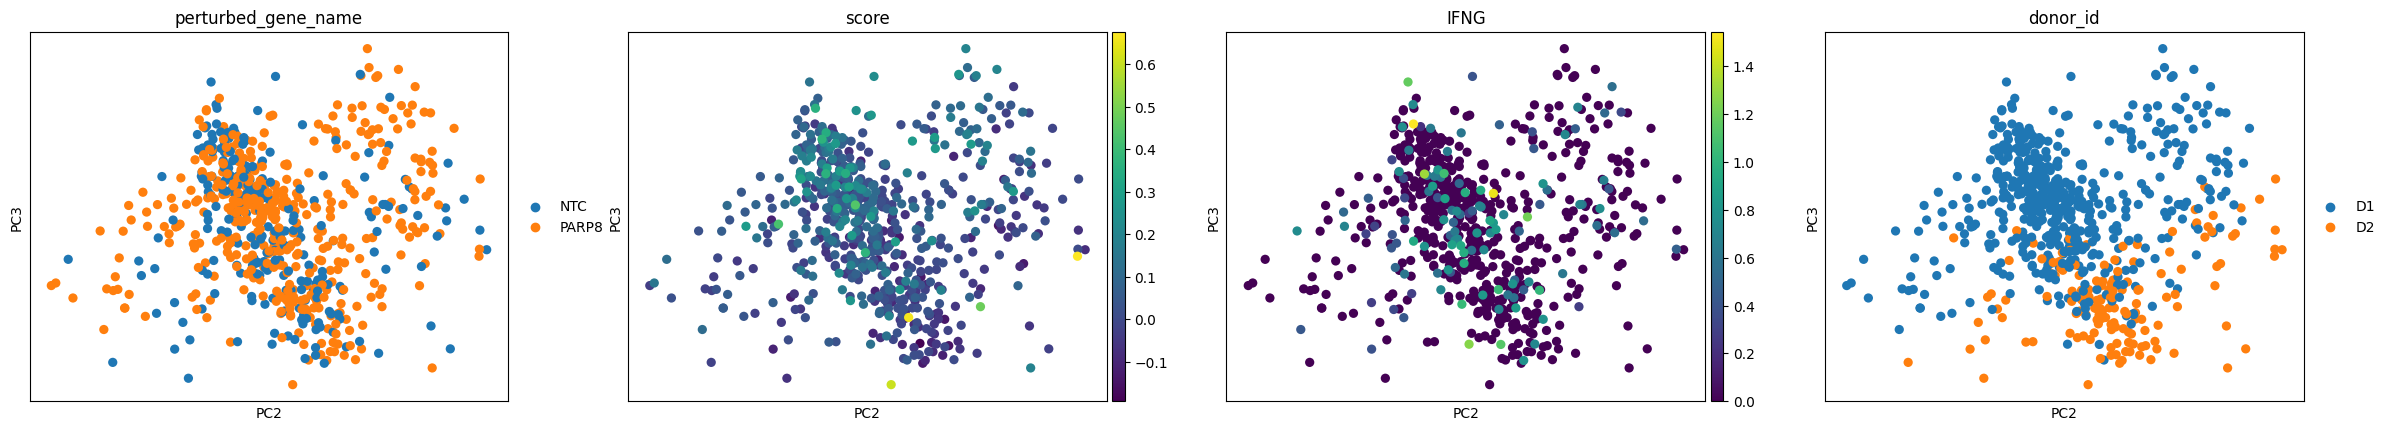

In [112]:
sc.pl.pca(adata_sc, color=['perturbed_gene_name', 'score', 'IFNG', 'donor_id'], components=['2,3'])

In [98]:
sc.pp.neighbors(adata_sc)
sc.tl.umap(adata_sc)

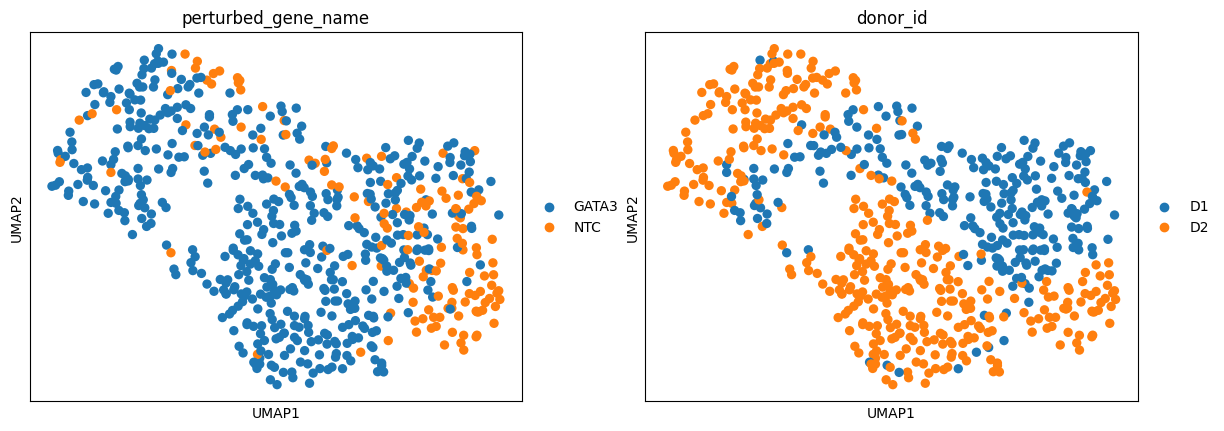

In [100]:
sc.pl.umap(adata_sc, color=['perturbed_gene_name','donor_id'])

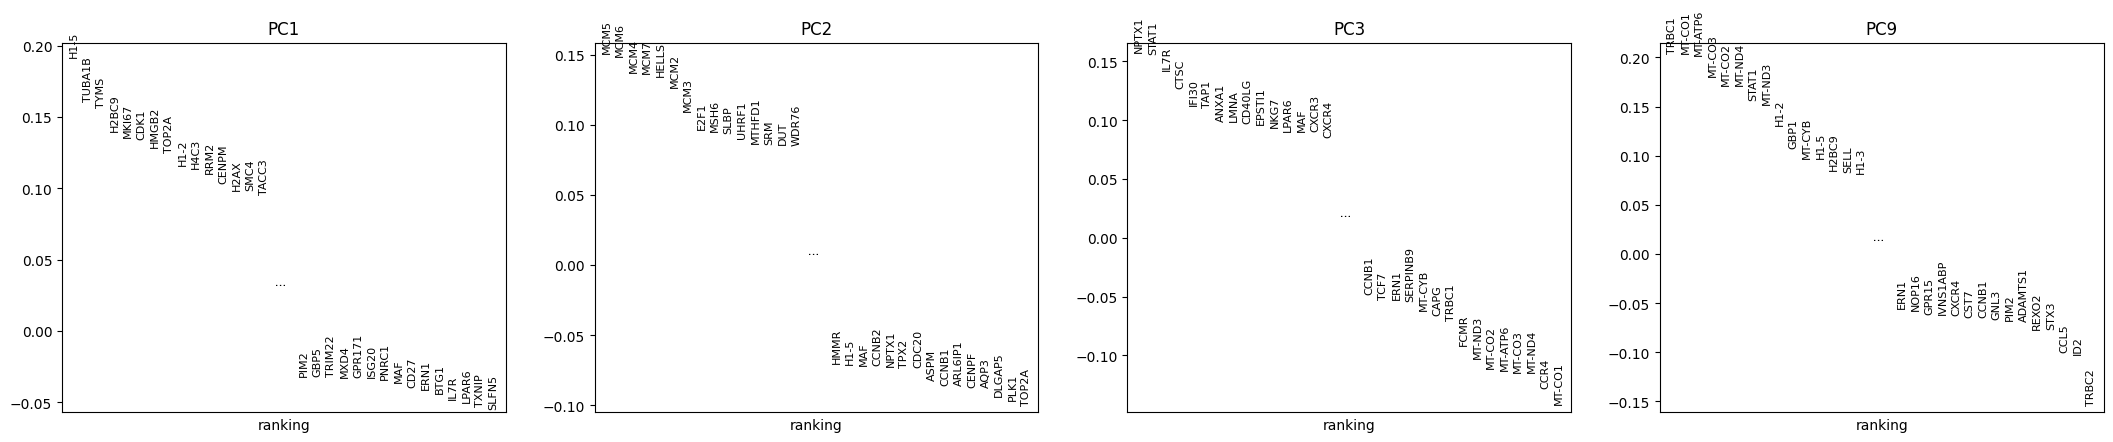

In [113]:
sc.pl.pca_loadings(adata_sc, components=[1,2,3, 9])